In [2]:
import os
import time

import keras
import numpy as np
import optuna
import pandas as pd
import sklearn
import talib
import tensorflow as tf
import tensorflow_addons as tfa
import yfinance as yf
from keras.callbacks import Callback, CSVLogger, EarlyStopping, ModelCheckpoint
from keras.layers import (LSTM, Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder
from tensorflow.keras.metrics import *

In [3]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [4]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(SEED)


def HMA(df: pd.DataFrame, timeperiod: int = 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(
        2 * talib.WMA(df, int(timeperiod / 2)) - talib.WMA(df, timeperiod),
        int(np.sqrt(timeperiod)),
    )
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = (
        df["Volume"]
        * (2 * df["Close"] - df["High"] - df["Low"])
        / (df["High"] - df["Low"])
    )
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df["Volume"].rolling(timeperiod).sum()


def pltcolor(lst: list) -> list:
    cols = []
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append("green")
        elif lst.iloc[i] == 2:
            cols.append("red")
    return cols


def trendNormalizePrices(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29, len(df)):
        model = LinearRegression()
        model.fit(
            np.array(df["rowNumber"].iloc[i - 29 : i + 1]).reshape(-1, 1),
            np.array(df["Close"].iloc[i - 29 : i + 1]),
        )
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1, 1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction
    df["Open"] = df["TN_Open"]
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(
        columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1
    )
    return df


def create_labels(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0] - 10):
        s = set(df["Close"].iloc[i : i + 11])
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i + 11):
            if df["Close"].iloc[j] == minPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 1
            elif df["Close"].iloc[j] == maxPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 2
    return df.iloc[6:-6]


def reverse_one_hot(predictions: np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions: np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0, 0, 0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)
    return np.array(predictions_one_hot)


def number_null_and_nan(df: pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return na + null

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [5]:
prices = yf.download(
    "SPY",
    start="2009-09-20",
    end="2023-01-01",
    interval="1d",
    progress=False,
    auto_adjust=True,
)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204712,83.066429,82.026161,82.639450,151892000
2009-09-22 00:00:00-04:00,83.128546,83.353680,82.755909,83.120781,143126700
2009-09-23 00:00:00-04:00,83.314862,83.866050,82.282352,82.429855,225947400
2009-09-24 00:00:00-04:00,82.608389,82.786940,81.164431,81.521538,228636800
2009-09-25 00:00:00-04:00,81.343003,81.793271,80.807339,81.086815,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


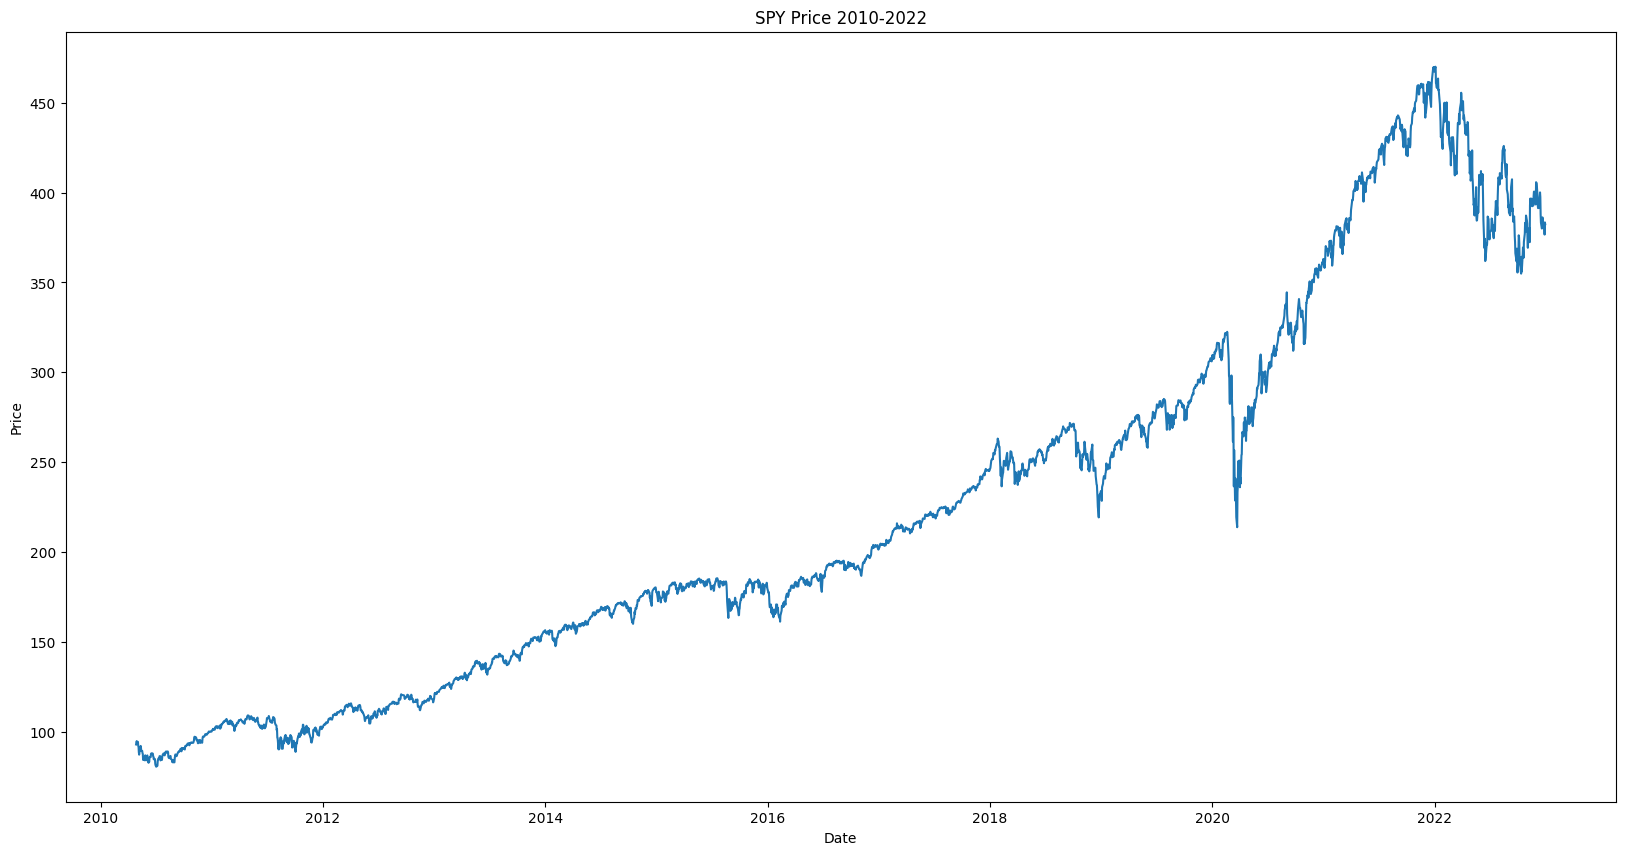

In [6]:
plt.figure(figsize=(20, 10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [7]:
tn_prices = trendNormalizePrices(prices)
tn_prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-11-02 00:00:00-05:00,-2.497218,-1.503522,-3.312352,-2.349715,254222900
2009-11-03 00:00:00-05:00,-2.646020,-1.823115,-2.801282,-1.939564,228362600
2009-11-04 00:00:00-05:00,-1.110644,-0.474060,-1.778281,-1.568677,247996700
2009-11-05 00:00:00-05:00,-0.968817,-0.021709,-1.139608,-0.044998,180015300
2009-11-06 00:00:00-05:00,-0.467010,0.417996,-0.630037,0.208386,170954100
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,-7.306054,-3.896050,-8.926049,-4.046044,59857300
2022-12-27 00:00:00-05:00,-2.835277,-2.475292,-5.975292,-4.225292,51638200
2022-12-28 00:00:00-05:00,-2.236787,-0.176759,-7.146761,-6.906770,70911500


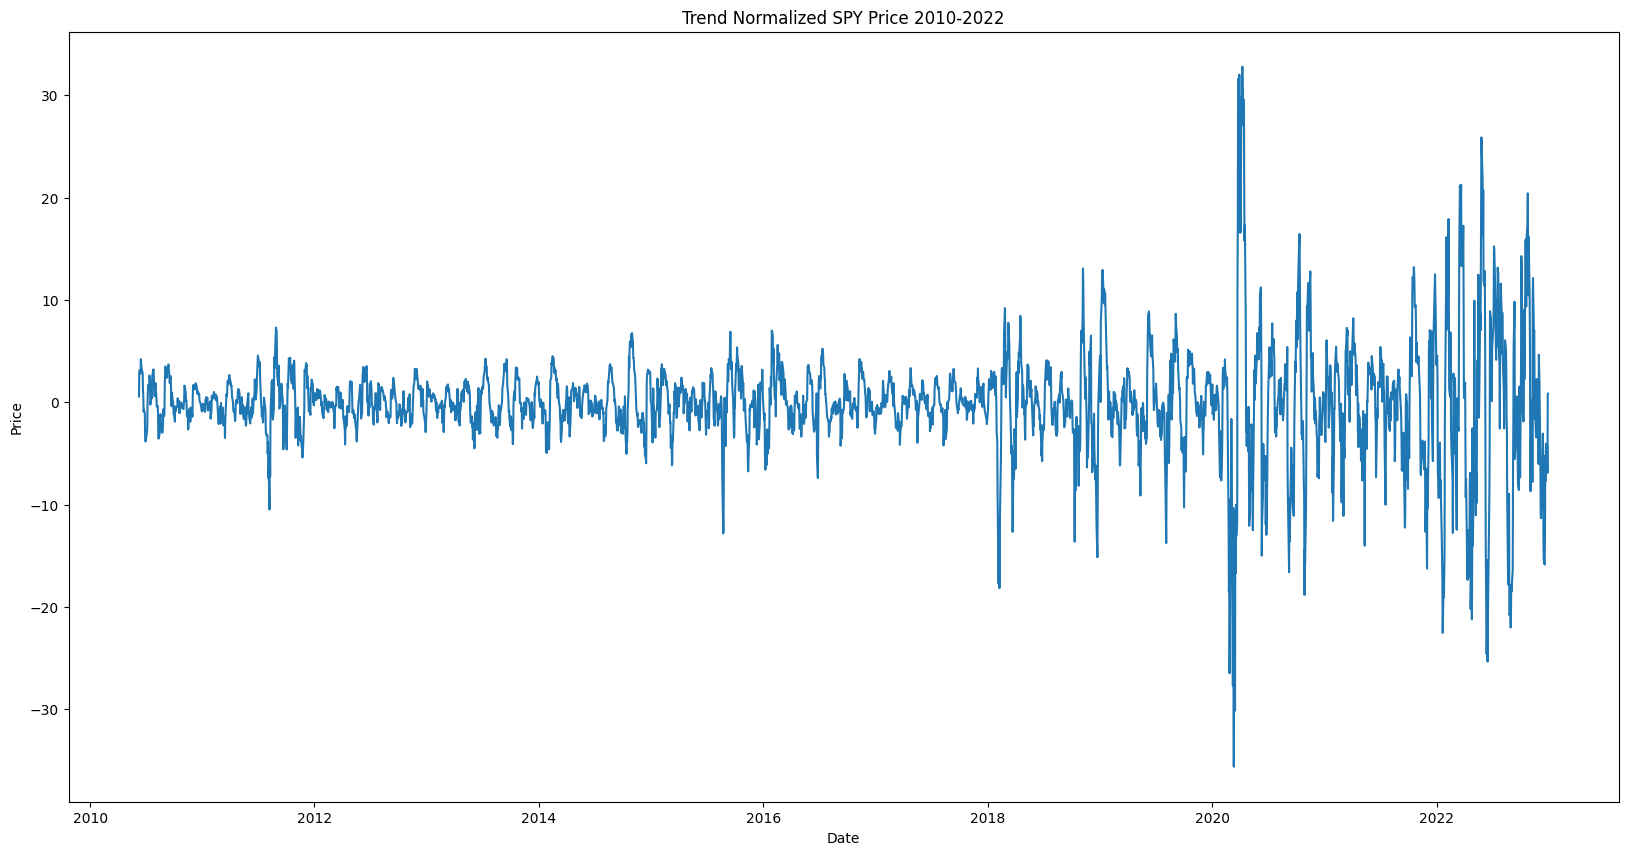

In [8]:
plt.figure(figsize=(20, 10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [9]:
prices_and_indicators = tn_prices.copy()

In [10]:
for i in range(7, 30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i + 7,
        slowk_period=i - 4,
    )[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i - 2,
        fastd_period=i - 4,
    )[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"HMA-{i}"] = HMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(
        prices_and_indicators["Close"], fastlimit=1 / i, slowlimit=1 / (i + 14)
    )[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(
        prices_and_indicators["Close"], timeperiod=i
    )[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(
        prices_and_indicators["High"], prices_and_indicators["Low"], maximum=1 / i
    )
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        fastperiod=i - 4,
        slowperiod=i + 3,
    )
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(
        prices_and_indicators["Close"], timeperiod=i
    )[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod=i)
prices_and_indicators["BOP"] = talib.BOP(
    prices_and_indicators["Open"],
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["TRANGE"] = talib.TRANGE(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["SAREXT"] = talib.SAREXT(
    prices_and_indicators["High"], prices_and_indicators["Low"]
)
prices_and_indicators["AD"] = talib.AD(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
    prices_and_indicators["Volume"],
)
prices_and_indicators["OBV"] = talib.OBV(
    prices_and_indicators["Close"], prices_and_indicators["Volume"]
)
prices_and_indicators.dropna(inplace=True)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [11]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [12]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [13]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

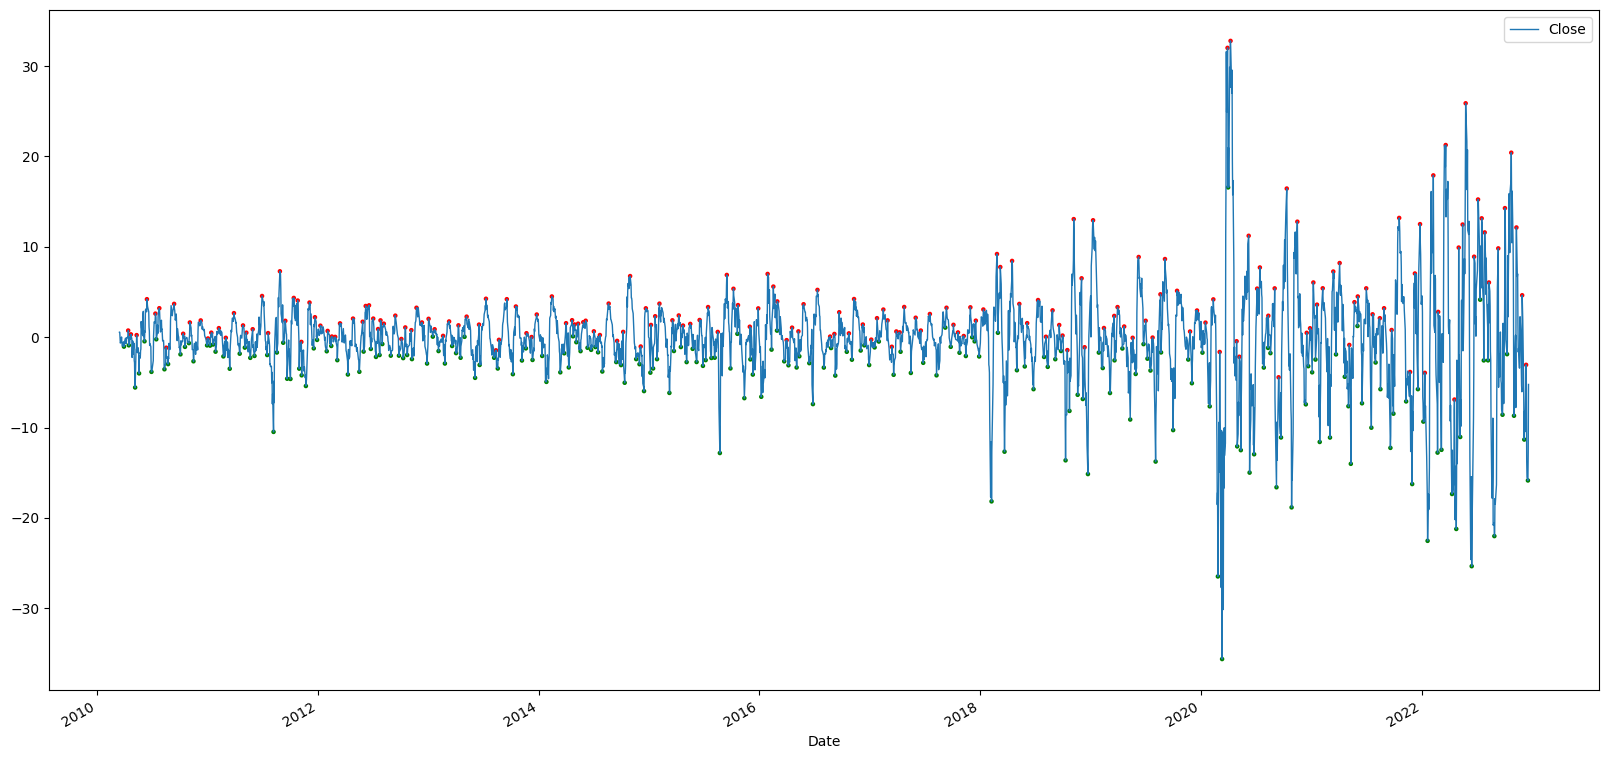

In [14]:
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(
    kind="line", stacked=False, linewidth=1
)
buy_and_sell_preds = prices_and_indicators_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<Figure size 5000x3000 with 0 Axes>

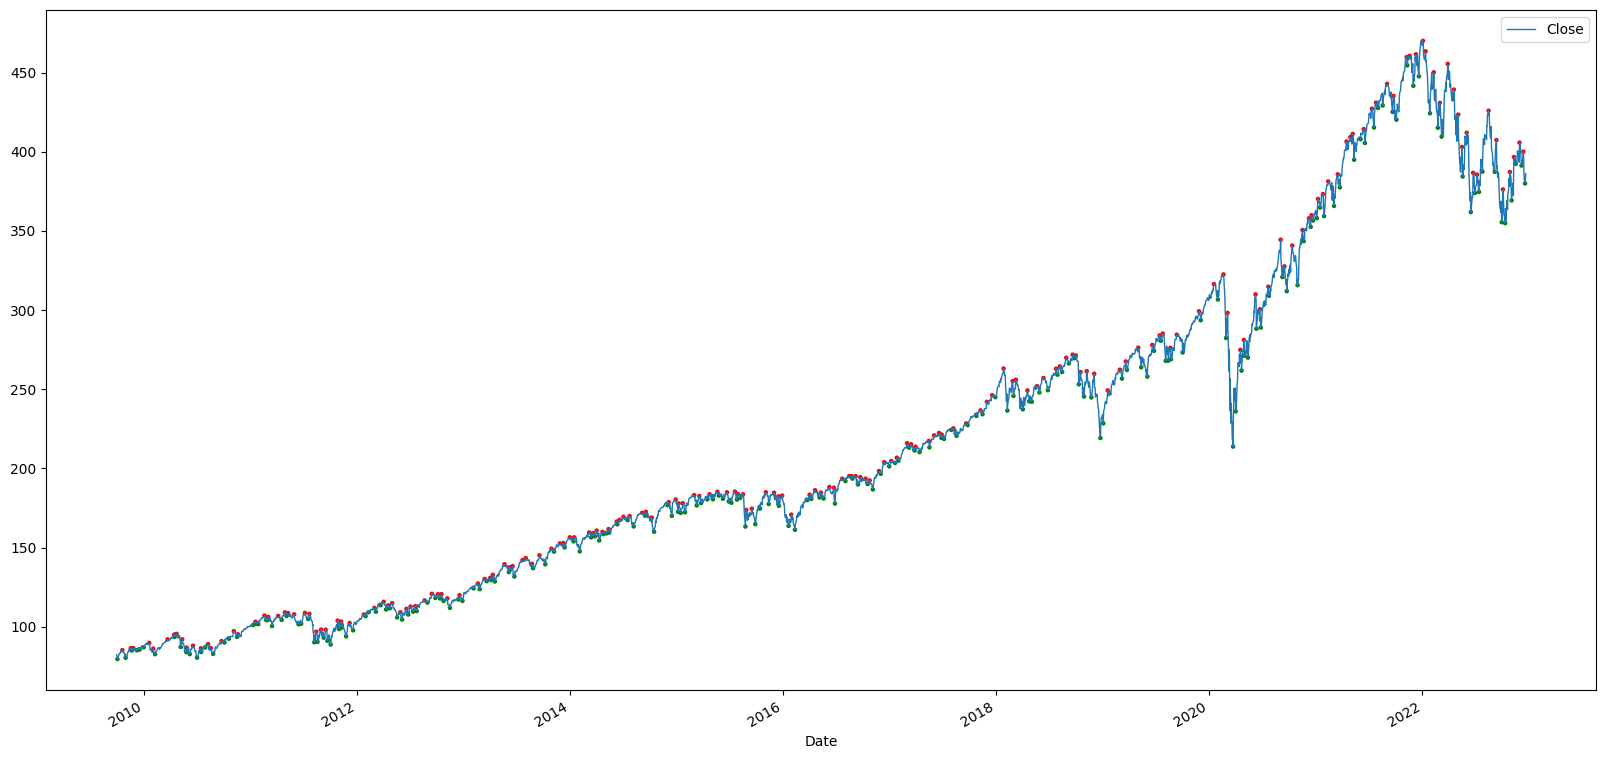

In [15]:
prices_with_label = create_labels(prices)
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False, linewidth=1)
buy_and_sell_preds = prices_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [16]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [17]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i-5}")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i}")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [18]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k=selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:, :-1], datas[i][0].iloc[:, -1])
    train_features = fitted.transform(datas[i][0].iloc[:, :-1])
    test_features = fitted.transform(datas[i][1].iloc[:, :-1])

    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label

    datas[i][0] = pd.DataFrame(
        data=train_features.astype("float32"),
        columns=selected_features,
        index=datas[i][0].index,
    )
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(
        data=test_features.astype("float32"),
        columns=selected_features,
        index=datas[i][1].index,
    )
    datas[i][1]["Label"] = test_label

In [19]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,37.759022,-52.957916,55.302181,-24.481953,39.590359,-58.704559,48.986652,-20.819281,41.267197,-58.704559,47.042084,-17.465605,42.725124,41.295441,-14.549754,41.295441,38.372013,37.564213,36.873806,36.290218,35.782421,35.329269,34.930786,34.585979,34.274845,33.999409,33.766006,33.551163,33.347504,33.156029,0
2010-03-17 00:00:00-04:00,37.574165,-51.516346,68.048241,-24.851669,39.431870,-53.440948,54.734337,-21.136259,41.128841,-59.128582,48.483654,-17.742319,42.602760,46.559052,-14.794479,40.871418,43.803894,42.837681,42.013535,41.317875,40.713558,40.175095,39.702213,39.293423,38.925011,38.599209,38.323307,38.069614,37.829334,37.603634,0
2010-03-18 00:00:00-04:00,28.814924,-75.487099,30.959532,-42.370152,31.710571,-78.286484,30.475565,-36.578857,34.252914,-79.148415,24.512901,-31.494175,36.432579,21.713518,-27.134844,20.851582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-19 00:00:00-04:00,21.401857,-82.355591,19.091541,-57.196285,24.677328,-84.927956,17.840082,-50.645344,27.633791,-86.248962,17.644407,-44.732418,30.235851,15.072045,-39.528297,13.751040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-22 00:00:00-04:00,29.434134,-56.419182,46.038223,-41.131733,31.283102,-56.809212,46.038223,-37.433796,33.145695,-62.088749,43.580818,-33.708614,34.901558,43.190788,-30.196888,37.911251,28.042353,27.259687,26.585009,26.005501,25.497971,25.045305,24.644547,24.292294,23.974360,23.690201,23.441961,23.214153,23.001009,22.802385,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,71.148216,-34.315777,40.716198,42.296436,69.421265,-33.947735,63.216263,38.842522,67.860603,-33.947735,65.684227,35.721207,66.457634,66.052261,32.915268,66.052261,38.979073,41.141876,42.997307,44.602478,46.001762,47.230053,48.315136,49.279343,50.140785,50.914288,51.612080,52.244305,52.819454,53.344658,0
2014-12-26 00:00:00-05:00,72.135529,-34.939873,70.905388,44.271049,70.322037,-32.595627,43.687923,40.644073,68.696175,-32.246033,65.060127,37.392349,67.240784,67.404373,34.481560,67.753967,41.010773,42.020409,42.945980,43.794701,44.573498,45.288868,45.946850,46.552956,47.112217,47.629166,48.577076,49.677555,50.677589,51.589787,0
2014-12-29 00:00:00-05:00,70.688492,-57.835823,50.266289,41.376984,69.128731,-35.885311,63.716663,38.257469,67.681168,-33.477627,42.164177,35.362331,66.358101,64.114693,32.716198,66.522369,6.391754,7.621639,8.741287,9.762362,10.695279,11.549328,12.332776,13.052972,13.716436,14.328956,14.895658,15.421085,15.909272,16.363792,0


In [20]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,42.520962,-7.703937e+01,23.589111,-14.958074,44.853794,-7.703937e+01,23.589111,-10.292416,46.391552,-7.703937e+01,22.960634,-7.216899,47.422096,22.960634,-5.155805,22.960634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,27.883072,-9.515691e+01,5.039082,-44.233856,31.124744,-9.524715e+01,4.843086,-37.750511,33.593559,-9.524715e+01,4.843086,-32.812885,35.501411,4.752849,-28.997175,4.752849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,24.230751,-8.982867e+01,11.567323,-51.538498,27.512751,-8.982867e+01,10.501955,-44.974499,30.088928,-8.998262e+01,10.171325,-39.822144,32.133114,10.171325,-35.733772,10.017382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,43.844463,-5.927728e+01,45.624680,-12.311074,44.374397,-6.055934e+01,44.853825,-11.251203,44.875710,-6.055934e+01,40.722721,-10.248577,45.310238,39.440659,-9.379526,39.440659,72.644104,71.864822,71.200592,70.626373,70.123772,69.679062,69.281830,68.924065,68.599503,68.303215,68.031242,67.780373,67.547974,67.331871,0
2015-01-08 00:00:00-05:00,58.889511,-1.480993e+01,96.452888,17.779018,57.927906,-2.265606e+01,86.654137,15.855815,57.212994,-2.509106e+01,85.190063,14.425984,56.644466,77.343933,13.288932,74.908936,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2015-01-09 00:00:00-05:00,50.927418,-3.386805e+01,71.318161,1.854834,50.845951,-3.498539e+01,71.318161,1.691904,50.813625,-4.097333e+01,66.131950,1.627251,50.794083,65.014618,1.588164,59.026672,75.166550,75.074799,74.993233,74.919861,74.853195,74.792068,74.735596,74.683075,74.633965,74.587830,74.544327,74.503159,74.464088,74.426933,0
2015-01-12 00:00:00-05:00,44.741325,-4.808104e+01,51.918961,-10.517348,45.298283,-5.185655e+01,51.918961,-9.403432,45.765770,-5.266996e+01,51.918961,-8.468462,46.151676,48.143448,-7.696651,47.330040,54.977863,54.753296,54.551109,54.367367,54.199020,54.043694,53.899525,53.765026,53.639015,53.520515,53.408726,53.302979,53.202705,53.107426,0
2015-01-13 00:00:00-05:00,43.234318,-5.285259e+01,28.193401,-13.531366,43.950302,-5.285259e+01,47.147408,-12.099393,44.541382,-5.628112e+01,47.147408,-10.917237,45.026978,47.147408,-9.946049,43.718880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,39.824760,-6.324821e+01,32.366489,-20.350475,40.918480,-6.324821e+01,32.366489,-18.163040,41.800426,-6.324821e+01,36.751793,-16.399147,42.518692,36.751793,-14.962617,36.751793,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [21]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(
        data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index
    )
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(
        data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index
    )
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [22]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,0.445694,-0.529579,0.553022,-0.350314,0.481722,-0.587046,0.489867,-0.323431,0.516423,-0.587046,0.470421,-0.291973,0.548754,0.412954,-0.259988,0.412954,0.383720,0.375642,0.368738,0.362902,0.357824,0.353293,0.349308,0.345860,0.342748,0.339994,0.337660,0.335512,0.333475,0.331560,0.0
2010-03-17 00:00:00-04:00,0.443512,-0.515163,0.680482,-0.355604,0.479794,-0.534409,0.547343,-0.328356,0.514692,-0.591286,0.484837,-0.296599,0.547182,0.465591,-0.264361,0.408714,0.438039,0.428377,0.420135,0.413179,0.407136,0.401751,0.397022,0.392934,0.389250,0.385992,0.383233,0.380696,0.378293,0.376036,0.0
2010-03-18 00:00:00-04:00,0.340121,-0.754871,0.309595,-0.606277,0.385844,-0.782865,0.304756,-0.568259,0.428646,-0.791484,0.245129,-0.526489,0.467933,0.217135,-0.484869,0.208516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-19 00:00:00-04:00,0.252620,-0.823556,0.190915,-0.818425,0.300266,-0.849280,0.178401,-0.786785,0.345813,-0.862490,0.176444,-0.747793,0.388344,0.150720,-0.706326,0.137510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-22 00:00:00-04:00,0.347430,-0.564192,0.460382,-0.588557,0.380642,-0.568092,0.460382,-0.581541,0.414790,-0.620887,0.435808,-0.563508,0.448269,0.431908,-0.539584,0.379113,0.280424,0.272597,0.265850,0.260055,0.254980,0.250453,0.246445,0.242923,0.239744,0.236902,0.234420,0.232142,0.230010,0.228024,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,0.839809,-0.343158,0.407162,0.605222,0.844695,-0.339477,0.632163,0.603426,0.849217,-0.339477,0.656842,0.597152,0.853570,0.660523,0.588158,0.660523,0.389791,0.411419,0.429973,0.446025,0.460018,0.472301,0.483151,0.492793,0.501408,0.509143,0.516121,0.522443,0.528195,0.533447,0.0
2014-12-26 00:00:00-05:00,0.851463,-0.349399,0.709054,0.633477,0.855655,-0.325956,0.436879,0.631413,0.859673,-0.322460,0.650601,0.625089,0.863628,0.674044,0.616146,0.677540,0.410108,0.420204,0.429460,0.437947,0.445735,0.452889,0.459468,0.465530,0.471122,0.476292,0.485771,0.496776,0.506776,0.515898,0.0
2014-12-29 00:00:00-05:00,0.834382,-0.578358,0.502663,0.592066,0.841135,-0.358853,0.637167,0.594337,0.846971,-0.334776,0.421642,0.591153,0.852291,0.641147,0.584601,0.665224,0.063918,0.076216,0.087413,0.097624,0.106953,0.115493,0.123328,0.130530,0.137164,0.143290,0.148957,0.154211,0.159093,0.163638,0.0


In [23]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,0.501903,-7.703937e-01,0.235891,-0.214036,0.545766,-7.703937e-01,0.235891,-0.159895,0.580550,-7.703937e-01,0.229606,-0.120645,0.609081,0.229606,-0.092128,0.229606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,0.329122,-9.515691e-01,0.050391,-0.632945,0.378716,-9.524715e-01,0.048431,-0.586461,0.420394,-9.524715e-01,0.048431,-0.548534,0.455974,0.047528,-0.518147,0.047528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,0.286011,-8.982867e-01,0.115673,-0.737468,0.334766,-8.982867e-01,0.105020,-0.698687,0.376537,-8.998262e-01,0.101713,-0.665708,0.412712,0.101713,-0.638522,0.100174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,0.517525,-5.927728e-01,0.456247,-0.176160,0.539933,-6.055934e-01,0.448538,-0.174789,0.561581,-6.055934e-01,0.407227,-0.171326,0.581957,0.394407,-0.167601,0.394407,0.726441,0.718648,0.712006,0.706264,0.701238,0.696791,0.692818,0.689241,0.685995,0.683032,0.680312,0.677804,0.675480,0.673319,0.0
2015-01-08 00:00:00-05:00,0.695111,-1.480993e-01,0.964529,0.254401,0.704848,-2.265606e-01,0.866541,0.246323,0.715971,-2.509106e-01,0.851901,0.241160,0.727531,0.773439,0.237458,0.749089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2015-01-09 00:00:00-05:00,0.601130,-3.386805e-01,0.713182,0.026541,0.618677,-3.498539e-01,0.713182,0.026284,0.635889,-4.097333e-01,0.661320,0.027203,0.652390,0.650146,0.028379,0.590267,0.751665,0.750748,0.749932,0.749199,0.748532,0.747921,0.747356,0.746831,0.746340,0.745878,0.745443,0.745032,0.744641,0.744269,0.0
2015-01-12 00:00:00-05:00,0.528111,-4.808104e-01,0.519190,-0.150493,0.551174,-5.185655e-01,0.519190,-0.146084,0.572719,-5.266996e-01,0.519190,-0.141568,0.592764,0.481434,-0.137530,0.473300,0.549779,0.547533,0.545511,0.543674,0.541990,0.540437,0.538995,0.537650,0.536390,0.535205,0.534087,0.533030,0.532027,0.531074,0.0
2015-01-13 00:00:00-05:00,0.510323,-5.285259e-01,0.281934,-0.193621,0.534773,-5.285259e-01,0.471474,-0.187966,0.557397,-5.628112e-01,0.471474,-0.182504,0.578318,0.471474,-0.177725,0.437189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,0.470078,-6.324821e-01,0.323665,-0.291196,0.497883,-6.324821e-01,0.323665,-0.282166,0.523096,-6.324821e-01,0.367518,-0.274145,0.546102,0.367518,-0.267365,0.367518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [24]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> MODEL INITIALIZATIONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [25]:
def create_model_MLP(
    trial=None, activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    MLP = Sequential()
    MLP.add(
        Dense(
            64,
            input_shape=(30,),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.HeUniform(),
        )
    )
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation="softmax"))
    MLP.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return MLP

In [26]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(
        monitor="val_f1_score", mode="max", verbose=1, patience=20, min_delta=1e-2
    )
    mcp = ModelCheckpoint(
        os.path.join(OUTPUT_PATH, f"best_CNN_model-{i+1}.h5"),
        monitor="val_f1_score",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
    )

    val_split_point = int(0.5 * len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(
        datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
    )
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(
        datas[i][0][val_split_point:].iloc[:, -1], num_classes=3
    )
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]

    model = create_model_MLP()
    model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=1,
        verbose=0,
        callbacks=[es, mcp],
        validation_data=(X_val, y_val),
        class_weight={0: 1, 1: 10, 2: 10},
    )
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))

print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time) / 60, 2)
print(f"\nCompleted in {minutes} minutes\n")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
8/8 [==============================] - 0s 3ms/step

Average f1-macro score: 0.26220261104844


Completed in 0.85 minutes



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [27]:
def create_model_LSTM(
    trial=None, activation_func="swish", dropout_rate=0.2, optimizer_algo="adam"
):
    LSTM_model = Sequential()
    LSTM_model.add(
        LSTM(
            units=64,
            return_sequences=True,
            input_shape=(30, 30),
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
        )
    )
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(LSTM(units=32, return_sequences=True, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(LSTM(units=32, return_sequences=False, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(Dense(3, activation="softmax"))
    LSTM_model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return LSTM_model

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [28]:
cnn_datas = []

In [29]:
df = datas[0][0].drop(columns=["Label"])
df_matrix_train = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix_train["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df_matrix_train.shape[0]):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30, -1))
    df_matrix_train.iloc[i, 0] = matrix
df_matrix_train["Label"] = datas[0][0].iloc[29:, -1]

df = datas[0][1].drop(columns=["Label"])
df_matrix_test = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix_test["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df_matrix_test.shape[0]):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30, -1))
    df_matrix_test.iloc[i, 0] = matrix
df_matrix_test["Label"] = datas[0][1].iloc[29:, -1]

In [30]:
df_matrix_test["Label"].value_counts()

0.0    195
1.0     16
2.0     12
Name: Label, dtype: int64

In [31]:
cnn_datas.append((df_matrix_train, df_matrix_test))

In [32]:
def create_model_CNN_2D(
    trial=None,
    activation_func="relu",
    dropout_rate=0.2,
    optimizer_algo="adam",
    kernel=3,
    pooling=3,
):
    CNN_2D = Sequential()
    CNN_2D.add(
        Conv2D(
            filters=64,
            kernel_size=(kernel, kernel),
            input_shape=(30, 30, 1),
            padding="same",
            activation=activation_func,
            kernel_initializer=tf.keras.initializers.HeUniform(),
        )
    )
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling), padding="same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(
        Conv2D(
            filters=64,
            kernel_size=(kernel, kernel),
            padding="same",
            activation=activation_func,
        )
    )
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling), padding="same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Flatten())
    CNN_2D.add(Dense(32, activation=activation_func))
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Dense(3, activation="softmax"))
    CNN_2D.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer_algo,
        metrics=[
            "accuracy",
            "Precision",
            "Recall",
            "AUC",
            tfa.metrics.F1Score(num_classes=3, average="macro"),
        ],
    )
    return CNN_2D

In [33]:
cnn_datas[0][1]["Label"].value_counts()

0.0    195
1.0     16
2.0     12
Name: Label, dtype: int64

In [34]:
cnn_datas[i][1].iloc[i, 1]

IndexError: list index out of range

In [ ]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for i in range(len(cnn_datas)):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for j in range(cnn_datas[i][0].shape[0]):
        X_train.append(cnn_datas[i][0].iloc[j, 0])
        y_train.append(
            tf.keras.utils.to_categorical(cnn_datas[i][0].iloc[j, 1], num_classes=3)
        )
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(
        X_train, newshape=(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    )
    X_train_list.append(X_train)
    y_train_list.append(y_train)

    for j in range(cnn_datas[i][1].shape[0]):
        X_test.append(cnn_datas[i][1].iloc[j, 0])
        y_test.append(cnn_datas[i][1].iloc[j, 1])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(
        X_test, newshape=(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    )
    X_test_list.append(X_test)
    y_test_list.append(y_test)

In [ ]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(cnn_datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(
        monitor="val_f1_score", mode="max", verbose=1, patience=20, min_delta=1e-2
    )
    mcp = ModelCheckpoint(
        os.path.join(OUTPUT_PATH, f"best_CNN_model-{i+1}.h5"),
        monitor="val_f1_score",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
    )

    # val_split_point = int(0.5*len(cnn_datas[i][0]))
    # X_train = X_train_list[i][:val_split_point]
    # y_train = tf.keras.utils.to_categorical(cnn_datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    # X_val = cnn_datas[i][0][val_split_point:].iloc[:, 0].values
    # y_val = tf.keras.utils.to_categorical(cnn_datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    # X_test = cnn_datas[i][1].iloc[:, 0].values
    # y_test = cnn_datas[i][1].iloc[:, -1]

    X_train = X_train_list[i]
    y_train = y_train_list[i]
    X_test = X_test_list[i]
    y_test = y_test_list[i]

    model = create_model_LSTM()
    model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=1,
        verbose=0,
        callbacks=[es, mcp],
        # validation_data=(X_val, y_val),
        class_weight={0: 1, 1: 10, 2: 10},
    )
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average="macro"))

print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time) / 60, 2)
print(f"\nCompleted in {minutes} minutes\n")

<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
set_random_seed()
start_time = time.time()


def objective(trial):
    activation_func = trial.suggest_categorical(
        name="activation_func", choices=["relu", "selu", "swish"]
    )
    dropout_rate = trial.suggest_categorical("drop_out_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical(
        "optimizer_algorithm", ["adam", "adadelta", "rmsprop"]
    )
    batch = trial.suggest_categorical("batch_size", [32, 64, 256])
    # epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    lr_max = trial.suggest_categorical("learning_rate_max", [1e-1, 1e-2, 1e-3, 1e-4])

    model = create_model_MLP(trial, activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(
            monitor="f1_score", mode="max", verbose=1, patience=20, min_delta=1e-2
        )
        mcp = ModelCheckpoint(
            os.path.join(OUTPUT_PATH, f"best_CNN_model-{i+1}.h5"),
            monitor="f1_score",
            verbose=0,
            save_best_only=True,
            save_weights_only=False,
            mode="max",
        )

        val_split_point = int(0.5 * len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(
            datas[i][0][:val_split_point].iloc[:, -1], num_classes=3
        )
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(
            X_train,
            y_train,
            batch_size=batch,
            epochs=1,
            verbose=0,
            callbacks=[es, mcp],
            class_weight={0: 1, 1: 10, 2: 10},
        )
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average="macro"))
    return np.mean(f1_scores)


study = optuna.create_study(
    study_name="MLP_Bayesian_Optimization",
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
)
study.optimize(objective, n_trials=5)
trial = study.best_trial

print("\n------------------------------------------")
print("Best F1 Macro: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time) / 60, 2)
print(f"\nCompleted in {minutes} minutes")

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>